In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or svg
%matplotlib inline

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

# Movies2_df

In [2]:
df = pd.read_csv('movies2_df.csv', index_col = 'title')

In [3]:
df.head()

,Year of Release,Domestic Distributor,Domestic Opening,Budget,MPAA Rating,Running Time,Genres,Original Release Gross Worldwide
title,,,,,,,,
Avatar,2009,Twentieth Century Fox,77025481,237000000,PG-13,162.0,"['Action', 'Adventure', 'Fantasy', 'Science fi...",2743577587
Avengers: Endgame,2019,Walt Disney Studios Motion Pictures,357115007,356000000,PG-13,181.0,"['Action', 'Adventure', 'Drama', 'Science fict...",2797501328
Titanic,1997,Paramount Pictures,28638131,200000000,PG-13,194.0,"['Drama', 'Romance']",1843478449
Star Wars: Episode VII - The Force Awakens,2015,Walt Disney Studios Motion Pictures,247966675,245000000,PG-13,138.0,"['Action', 'Adventure', 'Science fiction']",2068223624
Jurassic World,2015,Universal Pictures,208806270,150000000,PG-13,124.0,"['Action', 'Adventure', 'Science fiction']",1670400637


In [4]:
df.columns

Index(['Year of Release', 'Domestic Distributor', 'Domestic Opening', 'Budget',
       'MPAA Rating', 'Running Time', 'Genres',
       'Original Release Gross Worldwide'],
      dtype='object')

In [5]:
df.shape

(800, 8)

In [6]:
#sns.pairplot(df, height=2, plot_kws={'s': 6});

In [7]:
# We can see some multi-collinearity (e.g. between Budget and Domestic Opening)
# Running Lasso later should fix this !!
# What else to do for feature engineering?

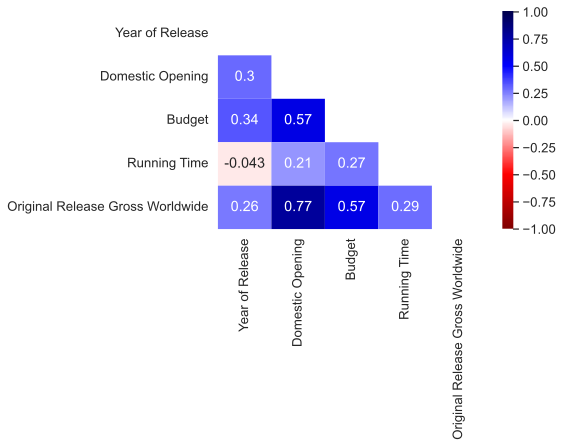

In [8]:
upper = np.triu(df.corr())  
sns.heatmap(df.corr(), cmap="seismic_r", annot=True, vmin=-1, vmax=1, mask=upper);

### VIF

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [10]:
def vif(df_X):
    '''
    Calculate the VIF for each feature of df_X (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [11]:
vif(df[['Year of Release', 'Domestic Opening', 'Budget', 'Running Time']])

Year of Release     32.388954
Domestic Opening     3.595167
Budget               5.437354
Running Time        34.902771
dtype: float64

In [12]:
vif(df[['Domestic Opening', 'Budget', 'Running Time']])

Domestic Opening    3.595159
Budget              5.435023
Running Time        3.953072
dtype: float64

## Baseline model

In [13]:
lr = LinearRegression()
X = df[['Year of Release', 'Domestic Opening', 'Budget', 'Running Time']]
y = df['Original Release Gross Worldwide']
lr.fit(X,y)
lr.score(X,y)

0.6340472596080484

## Diagnostic Plotting

In [14]:
import scipy.stats as stats

In [15]:
def diagnostic_plots(y_pred, y_true, resid):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

In [16]:
#Create the model
model = sm.OLS(y, sm.add_constant(X)) 

#Fit
fit = model.fit()

#Print out summary
fit.summary()

/Users/atrinsarmadi/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     Original Release Gross Worldwide   R-squared:                       0.634
Model:                                          OLS   Adj. R-squared:                  0.632
Method:                               Least Squares   F-statistic:                     344.4
Date:                              Thu, 30 Sep 2021   Prob (F-statistic):          7.32e-172
Time:                                      16:37:49   Log-Likelihood:                -16316.
No. Observations:                               800   AIC:                         3.264e+04
Df Residuals:                                   795   BIC:                         3.267e+04
Df Model:                                         4                                         
Covariance Type:                          nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.263e+09   1.59e+09     -0.792      0.428   -4.39e+09    1.87e+09
Year of Release   5.893e+05   7.93e+05      0.743      0.458   -9.68e+05    2.15e+06
Domestic Opening     5.3154      0.215     24.744      0.000       4.894       5.737
Budget               0.7713      0.132      5.848      0.000       0.512       1.030
Running Time      1.488e+06   3.12e+05      4.771      0.000    8.76e+05     2.1e+06
==============================================================================
Omnibus:                      657.778   Durbin-Watson:                   1.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26672.968
Skew:                           3.395   Prob(JB):                         0.00
Kurtosis:                      30.460   Cond. No.                     3.15e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

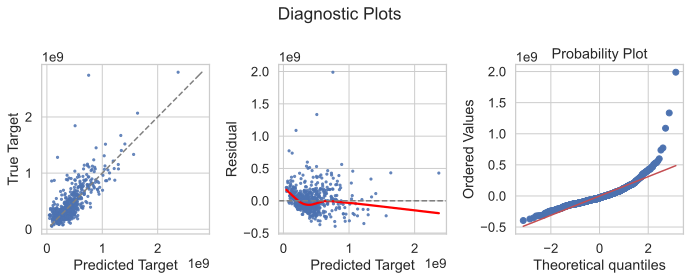

In [17]:
diagnostic_plots(fit.fittedvalues, y, fit.resid)

### Cross Validation

In [18]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([ -0.91874941,  -1.16092244,  -2.97479967,  -7.42388611,
       -39.00473347])

In [19]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cross_val_score(lm, X, y, cv=kf, scoring='r2')

array([0.65292186, 0.76625426, 0.51219868, 0.68945777, 0.44985198])

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X, y)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))

0.6238414180379948
0.6238414369018463


In [21]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

In [22]:
split_and_validate(X, y)


Validation R^2 score was: 0.5964812780064215
Feature coefficient results: 

Year of Release : 830069.93
Domestic Opening : 5.49
Budget : 0.71
Running Time : 1154553.60


# Movies4_df

In [23]:
df2 = pd.read_csv('movies4_df.csv', index_col = 'title')

In [24]:
df2.head()

,Action,Adventure,Animation,Budget,Comedy,Crime,Domestic Opening,Drama,Family,Fantasy,...,Other_Genres,Romance,Running Time,Science fiction,Thriller,Year of Release,Rating_G,Rating_PG,Rating_PG-13,Rating_R
title,,,,,,,,,,,,,,,,,,,,,
Avatar,1.0,1.0,0.0,237000000,0.0,0.0,77025481,0.0,0.0,1.0,...,0.0,0.0,162.0,1.0,0.0,2009,0,0,1,0
Avengers: Endgame,1.0,1.0,0.0,356000000,0.0,0.0,357115007,1.0,0.0,0.0,...,0.0,0.0,181.0,1.0,0.0,2019,0,0,1,0
Titanic,0.0,0.0,0.0,200000000,0.0,0.0,28638131,1.0,0.0,0.0,...,0.0,1.0,194.0,0.0,0.0,1997,0,0,1,0
Star Wars: Episode VII - The Force Awakens,1.0,1.0,0.0,245000000,0.0,0.0,247966675,0.0,0.0,0.0,...,0.0,0.0,138.0,1.0,0.0,2015,0,0,1,0
Jurassic World,1.0,1.0,0.0,150000000,0.0,0.0,208806270,0.0,0.0,0.0,...,0.0,0.0,124.0,1.0,0.0,2015,0,0,1,0


In [25]:
df2.fillna(0, inplace = True)

In [26]:
df2.describe()

,Action,Adventure,Animation,Budget,Comedy,Crime,Domestic Opening,Drama,Family,Fantasy,...,Other_Genres,Romance,Running Time,Science fiction,Thriller,Year of Release,Rating_G,Rating_PG,Rating_PG-13,Rating_R
count,800.000000,800.000000,800.000000,8.000000e+02,800.0000,800.00000,8.000000e+02,800.000000,800.00000,800.000000,...,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000
mean,0.482500,0.508750,0.147500,9.528034e+07,0.3850,0.13750,4.219684e+07,0.326250,0.23250,0.263750,...,0.272500,0.157500,117.094629,0.266250,0.275000,2007.612500,0.013750,0.20875,0.477500,0.237500
std,0.500006,0.500236,0.354825,5.987917e+07,0.4869,0.34459,3.553571e+07,0.469133,0.42269,0.440941,...,0.445524,0.364499,20.891669,0.442273,0.446794,8.459716,0.116524,0.40667,0.499806,0.425817
min,0.000000,0.000000,0.000000,1.500000e+04,0.0000,0.00000,7.787300e+04,0.000000,0.00000,0.000000,...,0.000000,0.000000,72.000000,0.000000,0.000000,1972.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,5.000000e+07,0.0000,0.00000,2.160522e+07,0.000000,0.00000,0.000000,...,0.000000,0.000000,101.000000,0.000000,0.000000,2002.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,8.500000e+07,0.0000,0.00000,3.403303e+07,0.000000,0.00000,0.000000,...,0.000000,0.000000,115.000000,0.000000,0.000000,2009.000000,0.000000,0.00000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.350000e+08,1.0000,0.00000,5.312889e+07,1.000000,0.00000,1.000000,...,1.000000,0.000000,130.000000,1.000000,1.000000,2014.000000,0.000000,0.00000,1.000000,0.000000
max,1.000000,1.000000,1.000000,3.560000e+08,1.0000,1.00000,3.571150e+08,1.000000,1.00000,1.000000,...,1.000000,1.000000,201.000000,1.000000,1.000000,2020.000000,1.000000,1.00000,1.000000,1.000000


In [27]:
lr = LinearRegression()
X = df2[df2.columns.difference(['Original Release Gross Worldwide'])]
y = df2['Original Release Gross Worldwide']
lr.fit(X,y)
lr.score(X,y)

0.6653147322287225

In [28]:
model = sm.OLS(y, sm.add_constant(X)) 

#Fit
fit = model.fit()

#Print out summary
fit.summary()

/Users/atrinsarmadi/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     Original Release Gross Worldwide   R-squared:                       0.665
Model:                                          OLS   Adj. R-squared:                  0.657
Method:                               Least Squares   F-statistic:                     77.43
Date:                              Thu, 30 Sep 2021   Prob (F-statistic):          1.16e-169
Time:                                      16:37:50   Log-Likelihood:                -16280.
No. Observations:                               800   AIC:                         3.260e+04
Df Residuals:                                   779   BIC:                         3.270e+04
Df Model:                                        20                                         
Covariance Type:                          nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.685e+09   1.69e+09     -1.584      0.114   -6.01e+09    6.43e+08
Action           -2.084e+07   1.73e+07     -1.204      0.229   -5.48e+07    1.32e+07
Adventure         3.927e+07   1.77e+07      2.219      0.027    4.53e+06     7.4e+07
Animation         9.702e+07   2.78e+07      3.492      0.001    4.25e+07    1.52e+08
Budget               0.4907      0.162      3.035      0.002       0.173       0.808
Comedy           -7.219e+06   1.77e+07     -0.407      0.684   -4.21e+07    2.76e+07
Crime            -2.416e+07   1.95e+07     -1.239      0.216   -6.24e+07    1.41e+07
Domestic Opening     5.3828      0.214     25.167      0.000       4.963       5.803
Drama             6.392e+06   1.58e+07      0.406      0.685   -2.45e+07    3.73e+07
Family            -1.39e+07   3.24e+07     -0.429      0.668   -7.75e+07    4.97e+07
Fantasy          -7.702e+06   1.73e+07     -0.445      0.656   -4.16e+07    2.62e+07
Other_Genres     -1.665e+07   1.51e+07     -1.100      0.272   -4.63e+07    1.31e+07
Rating_G          2.176e+07   5.91e+07      0.368      0.713   -9.43e+07    1.38e+08
Rating_PG        -1.972e+07   3.08e+07     -0.640      0.522   -8.02e+07    4.07e+07
Rating_PG-13     -4.057e+07   3.18e+07     -1.277      0.202   -1.03e+08    2.18e+07
Rating_R         -5.383e+07   3.31e+07     -1.625      0.105   -1.19e+08    1.12e+07
Romance          -2.505e+06   1.89e+07     -0.133      0.894   -3.95e+07    3.45e+07
Running Time      2.643e+06   4.04e+05      6.549      0.000    1.85e+06    3.44e+06
Science fiction  -3.068e+07   1.63e+07     -1.880      0.061   -6.27e+07    1.36e+06
Thriller         -8.769e+06   1.64e+07     -0.534      0.593    -4.1e+07    2.35e+07
Year of Release    1.26e+06   8.49e+05      1.484      0.138   -4.06e+05    2.93e+06
==============================================================================
Omnibus:                      688.234   Durbin-Watson:                   1.327
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34852.450
Skew:                           3.562   Prob(JB):                         0.00
Kurtosis:                      34.541   Cond. No.                     3.47e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.47e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

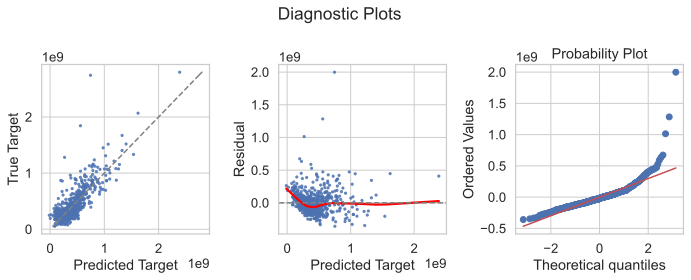

In [29]:
diagnostic_plots(fit.fittedvalues, y, fit.resid)

In [30]:
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([ -0.82087669,  -1.096217  ,  -3.79290673,  -7.18503806,
       -34.88205829])

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cross_val_score(lm, X, y, cv=kf, scoring='r2')

array([0.66774177, 0.75427872, 0.5150454 , 0.71534226, 0.49030836])

In [32]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

lm_reg = Ridge(alpha=10)
lm_reg.fit(X, y)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))

0.6411323176739081
0.6432864136494644


/Users/atrinsarmadi/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.3154e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/atrinsarmadi/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.41823e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/atrinsarmadi/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.0707e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/atrinsarmadi/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.89368e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/atrinsarmadi/opt/anaconda3/envs/metis/l

In [34]:
split_and_validate(X, y)


Validation R^2 score was: 0.5957235368824184
Feature coefficient results: 

Action : -8307996.32
Adventure : 50805033.82
Animation : 88785631.78
Budget : 0.41
Comedy : 2199107.75
Crime : -22851408.01
Domestic Opening : 5.62
Drama : 24782672.95
Family : -18453556.91
Fantasy : 17339632.12
Other_Genres : -11955423.80
Rating_G : 34213979.37
Rating_PG : -50594709.33
Rating_PG-13 : -48174716.15
Rating_R : -61661524.68
Romance : -3018603.55
Running Time : 2125470.97
Science fiction : -40649078.60
Thriller : -12886435.72
Year of Release : 1519529.11
